### Packages

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import importlib, import_ipynb
import data_clean_order as data
import tensorflow as tf
from tensorflow.data import experimental
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')

importing Jupyter notebook from data_clean_order.ipynb
Length of original data set 209527
Number of examples with no short description:  19712
Number of examples with no headline:  6


c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anacond

Stored 'test_df' (DataFrame)
Size of training data for headlines:  167616
Size of testing data for headlines:  41905
Size of training data for headlines:  151851
Size of testing data for headlines:  37963
Stored 'ordered_super_alpha_text' (DataFrame)
Stored 'ordered_class_alpha_text' (DataFrame)
Stored 'ordered_sem_clusters_desc_text' (DataFrame)
Stored 'ordered_sem_clusters_asc_text' (DataFrame)
Stored 'ordered_sem_clusters_shuffled_per_superclass_text' (DataFrame)


### Loading ordered data from data_clean_order_text.ipynb

In [2]:
%store -r ordered_super_alpha_text
%store -r ordered_class_alpha_text
%store -r ordered_sem_clusters_desc_text
%store -r ordered_sem_clusters_asc_text
%store -r ordered_sem_clusters_shuffled_per_superclass_text
%store -r test_df

In [3]:
# Experimental data orderings on headlines TRAIN EXAMPLES
X1_train = ordered_super_alpha_text['cleaned_headline']
X2_train = ordered_class_alpha_text['cleaned_headline']
X3_train = ordered_sem_clusters_desc_text['cleaned_headline']
X4_train = ordered_sem_clusters_asc_text['cleaned_headline']
X5_train = ordered_sem_clusters_shuffled_per_superclass_text['cleaned_headline']

# Experimental data orderings on short_description #TODO

# TRAIN LABELS
Y1_train = ordered_super_alpha_text['superclass']
Y2_train = ordered_class_alpha_text['superclass']
Y3_train = ordered_sem_clusters_desc_text['superclass']
Y4_train = ordered_sem_clusters_asc_text['superclass']
Y5_train = ordered_sem_clusters_shuffled_per_superclass_text['superclass']

# TEST EXAMPLES
X_test = test_df['cleaned_headline']
Y_test = test_df['superclass']



In [4]:
Y1_train[:100]

0     COMMUNITIES
1     COMMUNITIES
2     COMMUNITIES
3     COMMUNITIES
4     COMMUNITIES
         ...     
95    COMMUNITIES
96    COMMUNITIES
97    COMMUNITIES
98    COMMUNITIES
99    COMMUNITIES
Name: superclass, Length: 100, dtype: object

In [5]:
Y2_train[:100]

0     CULTURE
1     CULTURE
2     CULTURE
3     CULTURE
4     CULTURE
       ...   
95    CULTURE
96    CULTURE
97    CULTURE
98    CULTURE
99    CULTURE
Name: superclass, Length: 100, dtype: object

In [6]:
Y3_train[:100]

16073    POLITICS
15887    POLITICS
52907    POLITICS
65144    POLITICS
20548    POLITICS
           ...   
20385    POLITICS
73908    POLITICS
73055    POLITICS
35554    POLITICS
85986    POLITICS
Name: superclass, Length: 100, dtype: object

In [7]:
Y4_train[:100]

165072    CULTURE
184086    CULTURE
165662    CULTURE
184841    CULTURE
139248    CULTURE
           ...   
203690    CULTURE
178744    CULTURE
3489      CULTURE
138037    CULTURE
207441    CULTURE
Name: superclass, Length: 100, dtype: object

In [8]:
Y5_train[:100]

64441    POLITICS
49843    POLITICS
47091    POLITICS
48350    POLITICS
74906    POLITICS
           ...   
37146    POLITICS
44999    POLITICS
52134    POLITICS
47824    POLITICS
82756    POLITICS
Name: superclass, Length: 100, dtype: object

In [9]:
Y_test[:100]

18830            HEALTH
67575          POLITICS
55619       COMMUNITIES
98921          POLITICS
52838     ENTERTAINMENT
              ...      
1015           POLITICS
111664     SCIENCE_TECH
128303           HEALTH
204712        LIFESTYLE
43694          POLITICS
Name: superclass, Length: 100, dtype: object

## Tokenization and Vectorization


### One-hot encoding and indexing of train and test data

In [10]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 27380


# EXPERIMENT ORDER 1

In [14]:
# ORDER 1 TRAIN DATA
X_train = X1_train
Y_train = Y1_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 53672


### Model training using embedding layer and RNN (Baseline)

In [15]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 70)            3757040   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          17280     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 9)                 2

In [16]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

Epoch 1/15
1310/1310 [==============================] - 111s 76ms/step - loss: 1.5156 - accuracy: 0.4955
Epoch 2/15
1310/1310 [==============================] - 91s 69ms/step - loss: 1.1068 - accuracy: 0.6523
Epoch 3/15
1310/1310 [==============================] - 94s 72ms/step - loss: 1.0077 - accuracy: 0.6868
Epoch 4/15
1310/1310 [==============================] - 99s 75ms/step - loss: 0.9428 - accuracy: 0.7073
Epoch 5/15
1310/1310 [==============================] - 91s 69ms/step - loss: 0.8922 - accuracy: 0.7235
Epoch 6/15
1310/1310 [==============================] - 91s 69ms/step - loss: 0.8496 - accuracy: 0.7377
Epoch 7/15
1310/1310 [==============================] - 95s 73ms/step - loss: 0.8124 - accuracy: 0.7509
Epoch 8/15
1310/1310 [==============================] - 88s 68ms/step - loss: 0.7801 - accuracy: 0.7610
Epoch 9/15
1310/1310 [==============================] - 92s 70ms/step - loss: 0.7529 - accuracy: 0.7709
Epoch 10/15
1310/1310 [==============================] - 97s 74

In [17]:
# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

test loss and accuracy: 3.0659241676330566 0.19909319281578064


In [15]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    #plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    #plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

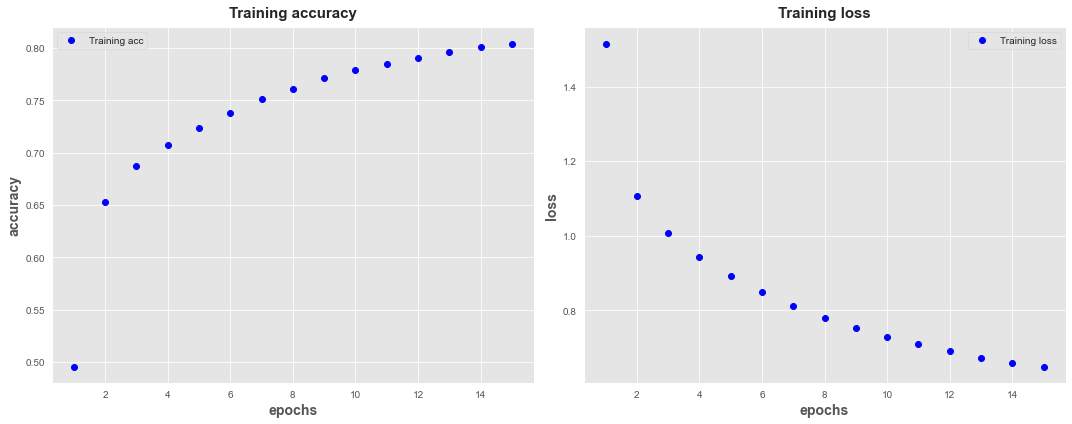

In [19]:
plot_loss_accuracy(history)

# EXPERIMENT ORDER 2

In [20]:
# ORDER 2 TRAIN DATA
X_train = X2_train
Y_train = Y2_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 57672


### Model training using embedding layer and RNN (Baseline)

In [21]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 70)            4037040   
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                

In [22]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
1310/1310 [==============================] - 101s 72ms/step - loss: 1.5113 - accuracy: 0.5010
Epoch 2/15
1310/1310 [==============================] - 103s 78ms/step - loss: 1.1105 - accuracy: 0.6492
Epoch 3/15
1310/1310 [==============================] - 97s 74ms/step - loss: 0.9973 - accuracy: 0.6884
Epoch 4/15
1310/1310 [==============================] - 97s 74ms/step - loss: 0.9336 - accuracy: 0.7098
Epoch 5/15
1310/1310 [==============================] - 108s 82ms/step - loss: 0.8858 - accuracy: 0.7249
Epoch 6/15
1310/1310 [==============================] - 113s 86ms/step - loss: 0.8418 - accuracy: 0.7399
Epoch 7/15
1310/1310 [==============================] - 112s 86ms/step - loss: 0.8059 - accuracy: 0.7519
Epoch 8/15
1310/1310 [==============================] - 95s 72ms/step - loss: 0.7744 - accuracy: 0.7629
Epoch 9/15
1310/1310 [==============================] - 90s 69ms/step - loss: 0.7464 - accuracy: 0.7723
Epoch 10/15
1310/1310 [==============================] - 91

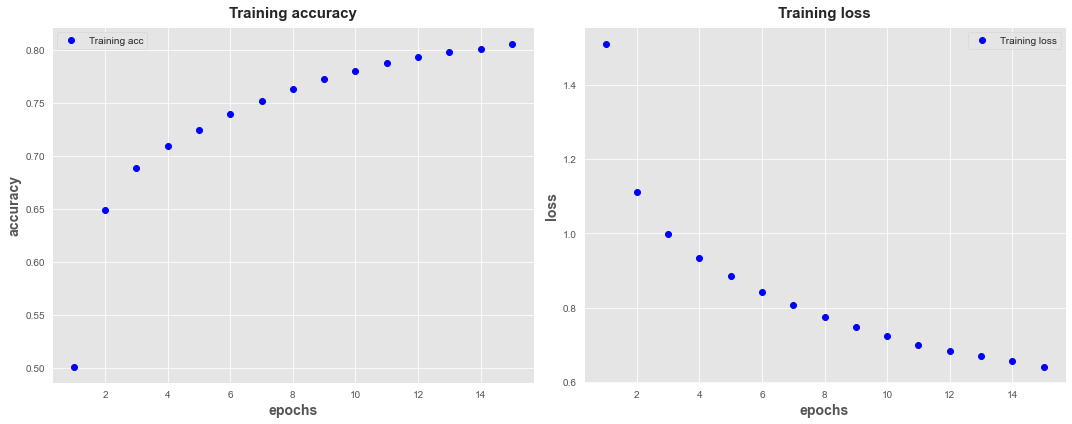

In [23]:
plot_loss_accuracy(history)

# EXPERIMENT ORDER 3

In [11]:
# ORDER 3 TRAIN DATA
X_train = X3_train
Y_train = Y3_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 57525


### Model training using embedding layer and RNN (Baseline)

In [12]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 70)            4026750   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          17280     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 9)                 2

In [13]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
1310/1310 [==============================] - 115s 79ms/step - loss: 1.5296 - accuracy: 0.4896
Epoch 2/15
1310/1310 [==============================] - 110s 84ms/step - loss: 1.1350 - accuracy: 0.6425
Epoch 3/15
1310/1310 [==============================] - 101s 77ms/step - loss: 1.0227 - accuracy: 0.6810
Epoch 4/15
1310/1310 [==============================] - 96s 73ms/step - loss: 0.9533 - accuracy: 0.7034
Epoch 5/15
1310/1310 [==============================] - 103s 79ms/step - loss: 0.8969 - accuracy: 0.7225
Epoch 6/15
1310/1310 [==============================] - 97s 74ms/step - loss: 0.8537 - accuracy: 0.7355
Epoch 7/15
1310/1310 [==============================] - 107s 82ms/step - loss: 0.8137 - accuracy: 0.7494
Epoch 8/15
1310/1310 [==============================] - 116s 88ms/step - loss: 0.7805 - accuracy: 0.7610
Epoch 9/15
1310/1310 [==============================] - 100s 77ms/step - loss: 0.7544 - accuracy: 0.7700
Epoch 10/15
1310/1310 [==============================] - 

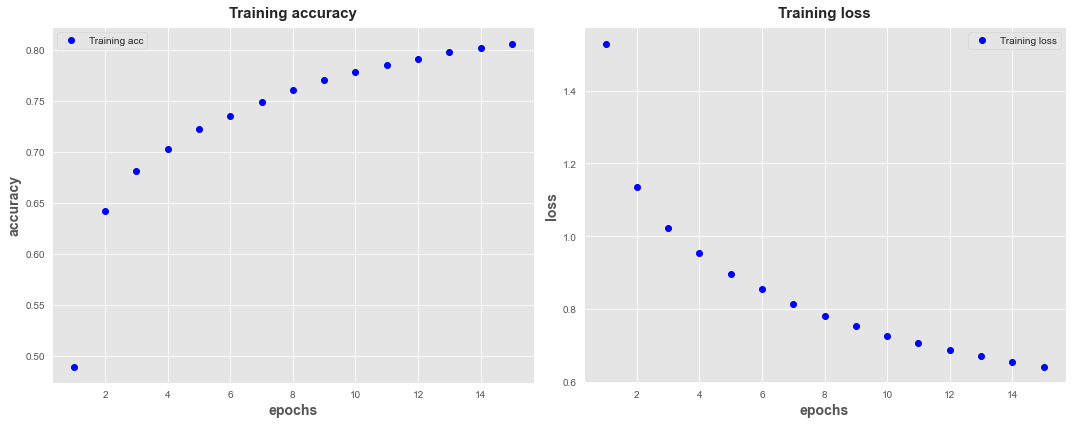

In [16]:
plot_loss_accuracy(history)

# EXPERIMENT ORDER 4

In [17]:
# ORDER 4 TRAIN DATA
X_train = X4_train
Y_train = Y4_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 57525


### Model training using embedding layer and RNN (Baseline)

In [18]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 70)            4026750   
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                

In [19]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
1310/1310 [==============================] - 111s 76ms/step - loss: 1.5436 - accuracy: 0.4859
Epoch 2/15
1310/1310 [==============================] - 110s 84ms/step - loss: 1.1235 - accuracy: 0.6453
Epoch 3/15
1310/1310 [==============================] - 102s 78ms/step - loss: 1.0028 - accuracy: 0.6867
Epoch 4/15
1310/1310 [==============================] - 109s 83ms/step - loss: 0.9374 - accuracy: 0.7091
Epoch 5/15
1310/1310 [==============================] - 101s 77ms/step - loss: 0.8898 - accuracy: 0.7235
Epoch 6/15
1310/1310 [==============================] - 103s 79ms/step - loss: 0.8479 - accuracy: 0.7382
Epoch 7/15
1310/1310 [==============================] - 107s 81ms/step - loss: 0.8104 - accuracy: 0.7498
Epoch 8/15
1310/1310 [==============================] - 102s 78ms/step - loss: 0.7821 - accuracy: 0.7595
Epoch 9/15
1310/1310 [==============================] - 106s 81ms/step - loss: 0.7522 - accuracy: 0.7694
Epoch 10/15
1310/1310 [==============================] 

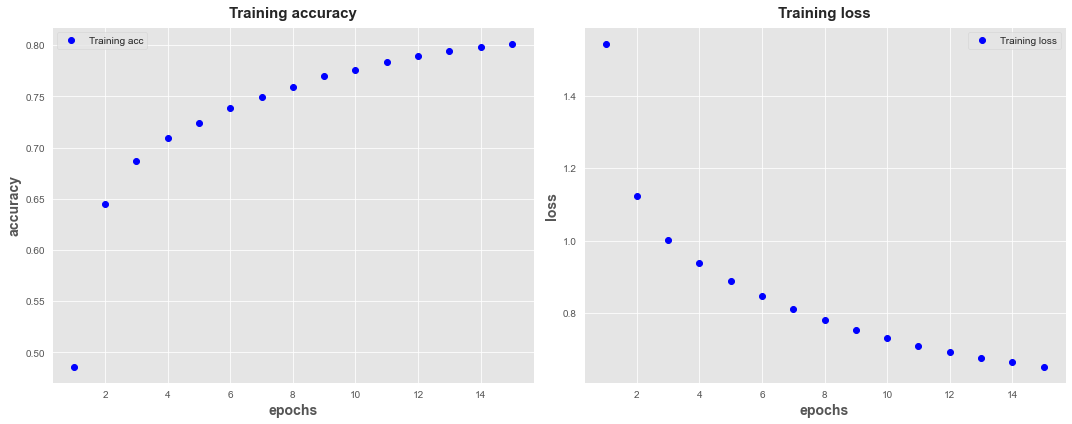

In [20]:
plot_loss_accuracy(history)

# EXPERIMENT ORDER 5

In [21]:
# ORDER 5 TRAIN DATA
X_train = X5_train
Y_train = Y5_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 5000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 57525


### Model training using embedding layer and RNN (Baseline)

In [22]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 70)            4026750   
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 128)          17280     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 9)                

In [23]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history = model.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
1310/1310 [==============================] - 107s 73ms/step - loss: 1.5157 - accuracy: 0.4954
Epoch 2/15
1310/1310 [==============================] - 106s 81ms/step - loss: 1.1120 - accuracy: 0.6494
Epoch 3/15
1310/1310 [==============================] - 112s 86ms/step - loss: 1.0067 - accuracy: 0.6849
Epoch 4/15
1310/1310 [==============================] - 114s 87ms/step - loss: 0.9418 - accuracy: 0.7068
Epoch 5/15
1310/1310 [==============================] - 116s 89ms/step - loss: 0.8922 - accuracy: 0.7236
Epoch 6/15
1310/1310 [==============================] - 118s 90ms/step - loss: 0.8504 - accuracy: 0.7372
Epoch 7/15
1310/1310 [==============================] - 114s 87ms/step - loss: 0.8113 - accuracy: 0.7501
Epoch 8/15
1310/1310 [==============================] - 109s 83ms/step - loss: 0.7825 - accuracy: 0.7598
Epoch 9/15
1310/1310 [==============================] - 103s 79ms/step - loss: 0.7571 - accuracy: 0.7688
Epoch 10/15
1310/1310 [==============================] 

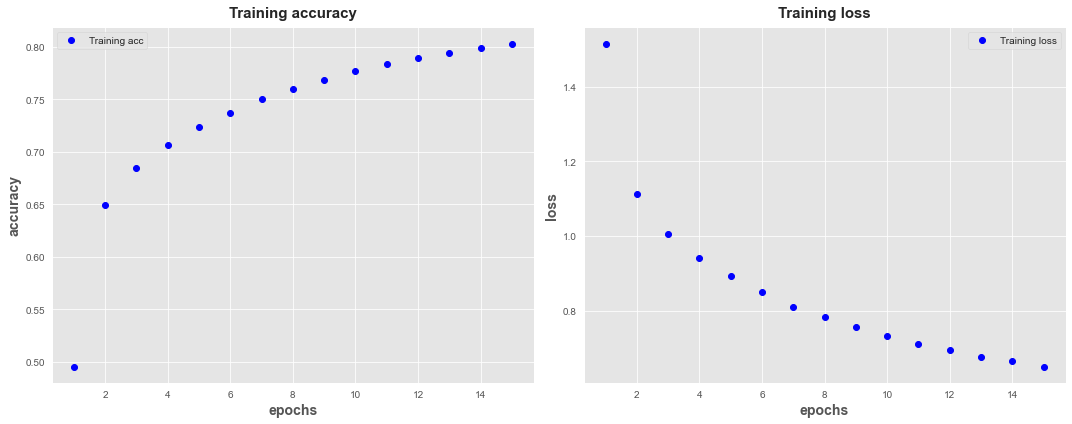

In [24]:
plot_loss_accuracy(history)